In [3]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import utm

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score, mean_squared_error, classification_report

import tensorflow as tf
import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, TimeDistributed, Input, Activation, concatenate
from keras.callbacks import History
from keras.models import Model

# The values have around 15 decimals, so for more clarity in reading we're increasing the number of displayed values
pd.set_option('display.float_format', '{:.15f}'.format)

# 1. Importing the data

In [222]:
sensor_and_loc_file = '../data/Processed/full_sensor_data_no_interpol_and_location.csv'

In [223]:
df_sensor_and_loc = pd.read_csv(sensor_and_loc_file, index_col=0)
df_sensor_and_loc

,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
12:15:51:60,0.558120700000000,0.496215820000000,9.361587999999999,0.074188230000000,0.290191650000000,-0.387237550000000,52.349854000000001,-50.549315999999997,-260.850520000000017,9.391328912221676,0.489558992696751,270.811252251747476,44.434937499999997,26.047601499999999
12:15:51:61,0.412078860000000,0.443542480000000,9.409470000000001,0.032653810000000,0.321075440000000,-0.377655030000000,NaN,NaN,NaN,9.428927012090160,0.496768589146909,NaN,NaN,NaN
12:15:51:62,0.378555300000000,0.465087900000000,9.435805999999999,0.018798828000000,0.324279800000000,-0.366989140000000,NaN,NaN,NaN,9.454842449217251,0.490093678290338,NaN,NaN,NaN
12:15:51:63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12:15:51:64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19:09:27:16,1.302719100000000,0.520156860000000,7.142166000000000,-0.118621826000000,-0.505569460000000,0.092132570000000,NaN,NaN,NaN,7.278610814164050,0.527408785424618,NaN,NaN,NaN
19:09:27:17,2.049713100000000,0.280731200000000,8.202788999999999,-0.301849370000000,-0.332992550000000,0.140075680000000,23.100280000000001,-16.200256000000000,-262.800599999999974,8.459662001373697,0.470763503951147,264.310852200404213,NaN,NaN
19:09:27:18,2.140686000000000,0.043701172000000,9.170044000000001,-0.590530400000000,0.304031370000000,0.046325684000000,23.100280000000001,-13.949585000000001,-261.749270000000024,9.416695455676912,0.665813259304968,263.136645496752351,NaN,NaN
19:09:27:19,1.896484400000000,-0.226837160000000,9.799728000000000,-0.686401370000000,0.651306150000000,-0.067657470000000,NaN,NaN,NaN,9.984126253738191,0.948643281224560,NaN,NaN,NaN


In [224]:
df_sensor_and_loc.loc[:, 'lat'].interpolate(method='linear', inplace=True)
df_sensor_and_loc.loc[:, 'long'].interpolate(method='linear', inplace=True)
df_sensor_and_loc.dropna(inplace=True)
df_sensor_and_loc.shape

(31074, 14)

## 1.1. Creating x and y

In [225]:
# df_sensor_and_loc['x'] = np.nan
# df_sensor_and_loc['y'] = np.nan
# for i in range(len(df_sensor_and_loc)):
#     lat = df_sensor_and_loc['lat'].iloc[i]
#     long = df_sensor_and_loc['long'].iloc[i]
#     df_sensor_and_loc['x'].iloc[i], df_sensor_and_loc['y'].iloc[i], zone, ut = utm.from_latlon(df_sensor_and_loc['lat'].iloc[i], df_sensor_and_loc['long'].iloc[i])
# df_sensor_and_loc

In [226]:
# plt.scatter(x=df_sensor_and_loc['x'], y=df_sensor_and_loc['y'])

In [290]:
data = df_sensor_and_loc.copy(deep=True)[::1]
data = data.iloc[:(len(data)//3), :]
print(data.shape)
data

(1036, 14)


,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
12:15:51:60,0.558120700000000,0.496215820000000,9.361587999999999,0.074188230000000,0.290191650000000,-0.387237550000000,52.349854000000001,-50.549315999999997,-260.850520000000017,9.391328912221676,0.489558992696751,270.811252251747476,44.434937499999997,26.047601499999999
12:15:51:87,1.343414300000000,1.456283600000000,8.241104000000000,-0.245376590000000,-0.293579100000000,-0.097488400000000,55.650329999999997,-49.349975999999998,-260.699459999999988,8.475925851722007,0.394844712528100,271.102541125311234,44.434937499999876,26.047603625360832
12:15:52:07,1.060897800000000,1.839355500000000,10.173218000000000,0.218002320000000,-0.320205700000000,0.119827270000000,55.650329999999997,-47.850037000000000,-261.300659999999993,10.392453861959124,0.405481536538380,271.412269778736913,44.434937499999791,26.047605199702190
12:15:52:27,0.146316530000000,-0.353729250000000,11.063858000000000,-0.285858150000000,0.275268550000000,-0.012268066000000,57.150269999999999,-50.100707999999997,-258.450319999999977,11.070478162817576,0.397036726240666,269.393396747723841,44.434937499999705,26.047606774043548
12:15:52:47,0.246871950000000,0.060470580000000,8.296173000000000,0.378860470000000,0.111221310000000,0.369094850000000,57.600403000000000,-52.049255000000002,-257.550049999999999,8.300065595925814,0.540496479010973,268.996207458060496,44.434937499999620,26.047608348384905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14:26:07:28,-0.512084960000000,-0.691314700000000,8.518829000000000,0.028396606000000,0.006820678700000,-0.397888180000000,25.650023999999998,-26.400756999999999,-260.099800000000016,8.562160624044337,0.398958509965586,262.691510447927612,44.434933003378205,26.047854654064523
14:26:07:48,-1.419494600000000,1.032516500000000,11.631287000000000,-0.083465576000000,0.134658810000000,0.013305664000000,24.150085000000001,-26.699829999999999,-261.599730000000022,11.762988247829307,0.158985968507000,264.065382554414043,44.434933003378035,26.047857802746996
14:26:07:68,-1.397949200000000,-0.609909060000000,12.663193000000000,0.055023193000000,-0.117813110000000,0.314773560000000,22.349547999999999,-27.299499999999998,-262.800599999999974,12.754713167394227,0.340572862587231,265.158293018367203,44.434933003377864,26.047860811488025
14:26:07:88,-0.224792480000000,-1.397598300000000,7.702408000000000,0.344772340000000,0.131469730000000,0.405319200000000,23.849487000000000,-28.050232000000001,-265.350340000000017,7.831404833469628,0.548120342829920,267.892546524782233,44.434933003377715,26.047863610316888


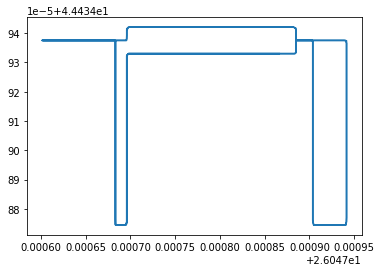

In [291]:
plt.plot(data['long'], data['lat'])

In [292]:
# plt.plot(data['x'], data['y'])

# 2. Creating the LSTM model

## 2.1. Scaling the data

In [293]:
backcandles=100

sc_attributes = MinMaxScaler(feature_range=(-1, 1))
attributes_scaled = sc_attributes.fit_transform(data.iloc[:, :-2])

sc_targets = MinMaxScaler(feature_range=(0, 1))
targets_scaled = sc_targets.fit_transform(data.iloc[backcandles:, [-2, -1]])
# y_test_1 = data.iloc[:, [-2, -1]]
# print(y_test_1)
# y_test_sc = sc.fit_transform(data.iloc[:, [-2, -1]])
# print(data_scaled)

In [294]:
print(attributes_scaled.shape[0], attributes_scaled.shape[1], targets_scaled.shape)

1036 12 (936, 2)


## 2.2. Principal Component Analysis (PCA)

In [295]:
# pca = PCA(n_components=3)

In [296]:
# pca.fit_transform(attributes_scaled)

## 2.2. Reshaping the data in order to feed it to the model

In [297]:
# The following cell does this:

# []
# i = 0
# X = [[]]
# for j in range(30, 8611)
#     J = 30
#     X[0].append(data_scaled[30-30=0:30, 0]) --> append and array
#     J = 31
#     X[0].append(31-30=1:31, 0)
#     
# i = 1
# X = [
#       [  <-- 12 of those
#        [5.5811, 5.4786, .., 5.1232  <--- 30 (backcandles) of those], [], ..., [] <--- 8581 of those
#       ],
#      [
#        [5.5811, 5.4786, .., 5.1232], [], ..., []
#      ]
#    ]   ---> 
# for j in range(30, 8611)
#     X[0].append(data_scaled[30-30:30, 0])

In [298]:
X = []
backcandles=backcandles # number of last values to look into

for i in range(12): #number of attributes columns
    X.append([])
    for j in range(backcandles, attributes_scaled.shape[0]):
        X[i].append(attributes_scaled[j-backcandles:j, i])
        
# move axis from 0 to position 2
X = np.moveaxis(X, [0], [2])

# We need shape (8581, 30, 12) = (rows, val of past attributes, columns) for LSTM training
X.shape

(936, 100, 12)

In [299]:
# Transform X and the targets (lat and long columns) into arrays so the axis can be moved and the data 
# to be used in the LSTM model
X, y = np.array(X), np.array(targets_scaled)

# Move the axis for yi, so instead of (8581, 2) we'll have (8581, 1, 2)
# I HAVE MODIFIED THIS:
# y = np.reshape(yi,(len(yi), 1, 2))
# y = np.reshape(yi,(len(yi), 2))

print('X Shape: ',X.shape)
print('y shape: ', y.shape)
targets_scaled

X Shape:  (936, 100, 12)
y shape:  (936, 2)


array([[0.41333355, 0.2772144 ],
       [0.44296318, 0.2772144 ],
       [0.47259281, 0.2772144 ],
       ...,
       [0.86666677, 0.76236629],
       [0.86666676, 0.77060316],
       [0.86666676, 0.77884003]])

## 2.3. Split the data into train, test and validation sets

In [300]:
splitlimit_test = int(len(X) * 0.7)
splitlimit_val = int(len(X) * 0.9)

print(splitlimit_test, splitlimit_val)
X_train, X_test, X_val = X[:splitlimit_test], X[splitlimit_test:splitlimit_val], X[splitlimit_val:]
y_train, y_test, y_val = y[:splitlimit_test], y[splitlimit_test:splitlimit_val], y[splitlimit_val:]
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

655 842
(655, 100, 12)
(187, 100, 12)
(94, 100, 12)
(655, 2)
(187, 2)
(94, 2)


## 2.4. Creating the LSTM  model

### 2.4.1. Create function to plot the training

In [301]:
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

### 2.4.2. Parametrizing the model

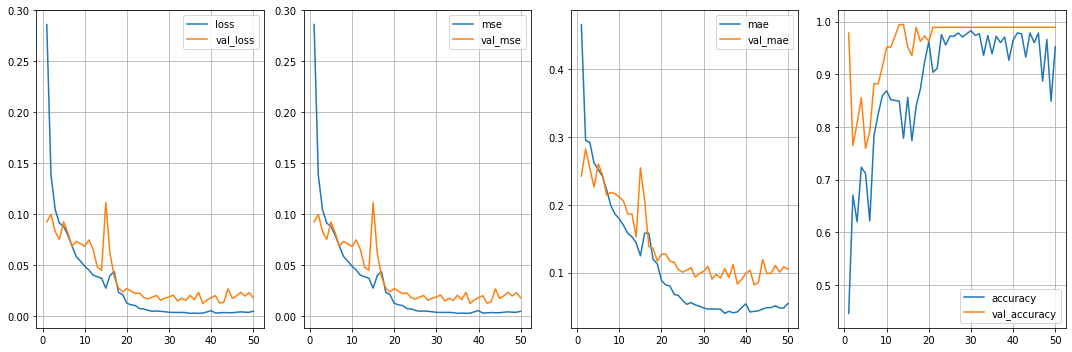

7/7 [==============================] - 1s 221ms/step - loss: 0.0049 - mse: 0.0049 - mae: 0.0548 - accuracy: 0.9527 - val_loss: 0.0180 - val_mse: 0.0180 - val_mae: 0.1052 - val_accuracy: 0.9893


In [302]:
attributes_cols = 12
batch_size=100
epochs=50

lstm_input = Input(shape=(backcandles, attributes_cols), name='lstm_input')
inputs = LSTM(128, activation='relu', name='first_layer', return_sequences=False)(lstm_input)
# inputs = LSTM(64, activation='relu', name='second_layer', return_sequences=False)(inputs)
inputs = Dense(2, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()

model.compile(optimizer=adam, loss='mse', metrics=['mse', 'mae', 'accuracy'])
model.fit(x=X_train, 
          y=y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          shuffle=False, 
          validation_data=(X_test, y_test), 
          callbacks=[PlotLearning()])

# model = Sequential()
# model.add(LSTM(128, activation='relu', name='first_layer', return_sequences=True))
# model.add(LSTM(128, activation='relu', name='second_layer', return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(2, name='dense_layer'))
# model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# model.fit(X_train, y_train, epochs=epochs)

In [303]:
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])
len(y_pred), len(y_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

6/6 [==============================] - 0s 20ms/step
[0.9111256 0.7639677] [1.         0.81745026]
[0.9011622 0.7598528] [0.99999999 0.80725713]
[0.9212759 0.744255 ] [0.99999999 0.79799064]
[0.9145963 0.7251177] [0.99999999 0.78954784]
[0.9128354 0.7362959] [0.99999999 0.78131097]
[0.93606895 0.73933536] [0.99999998 0.77266225]
[0.9415684 0.7102506] [0.99999998 0.762778  ]
[0.9563381  0.72155344] [0.99999998 0.75212154]
[0.9520734 0.7318607] [0.99999998 0.74285506]
[0.93318635 0.69716   ] [0.99999997 0.73358857]
Mean Squared Error (MSE): 0.017993769850697672
R-squared: 0.48005421116356756


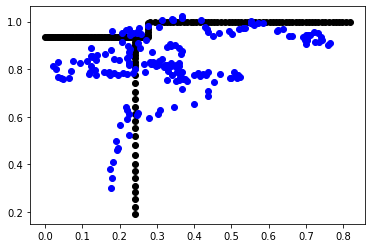

In [304]:
plt.scatter(y_test[:, 1], y_test[:, 0], color='black', label='Test')
plt.scatter(y_pred[:, 1], y_pred[:, 0], color='blue', label='Pred')

Mean Squared Error (MSE): 1.4458985226339672e-09
R-squared: 0.41851363344732617
[[44.434942   26.04787953]
 [44.434942   26.04787607]
 [44.434942   26.04787292]
 [44.434942   26.04787005]
 [44.434942   26.04786725]
 [44.434942   26.04786431]
 [44.434942   26.04786095]
 [44.434942   26.04785733]
 [44.434942   26.04785418]
 [44.434942   26.04785103]
 [44.434942   26.04784788]
 [44.434942   26.04784486]
 [44.434942   26.0478422 ]
 [44.434942   26.04783926]
 [44.434942   26.04783646]
 [44.434942   26.04783356]
 [44.434942   26.04783041]
 [44.434942   26.04782726]
 [44.434942   26.04782411]
 [44.434942   26.04782107]
 [44.434942   26.04781813]
 [44.434942   26.04781533]
 [44.434942   26.04781253]
 [44.434942   26.04780973]
 [44.434942   26.04780664]
 [44.434942   26.04780333]
 [44.434942   26.04780034]
 [44.434942   26.04779672]
 [44.434942   26.04779357]
 [44.434942   26.04779042]
 [44.434942   26.04778696]
 [44.434942   26.04778381]
 [44.434942   26.0477805 ]
 [44.434942   26.04777757]
 [

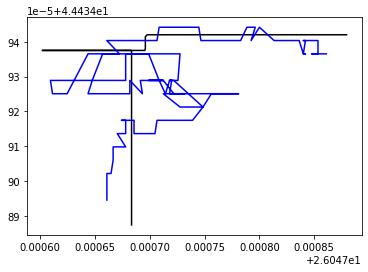

In [305]:
y_test_normalized = sc_targets.inverse_transform(y_test)
y_pred_normalized = sc_targets.inverse_transform(y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_normalized, y_pred_normalized)
print("Mean Squared Error (MSE):", mse)

# Calculate R-squared
r2 = r2_score(y_test_normalized, y_pred_normalized)
print("R-squared:", r2)

plt.plot(y_test_normalized[:, 1], y_test_normalized[:, 0], color='black', label='Test')
plt.plot(y_pred_normalized[:, 1], y_pred_normalized[:, 0], color='blue', label='Pred')
print(y_test_normalized, y_pred_normalized)

In [306]:
model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 21ms/step - loss: 0.0180 - mse: 0.0180 - mae: 0.1052 - accuracy: 0.9893


[0.01799377053976059,
 0.01799377053976059,
 0.10523763298988342,
 0.9893048405647278]